## Basic workflow of Scarf

This workflow is meant to familiarize users with the Scarf API and how data is internally handled in Scarf. Please checkout the quick start guide if you are interested in the minimal steps required to run the analysis.

In [1]:
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

import scarf
scarf.__version__

'0.6.3'

time: 739 ms


Download the data from 10x's website using the `fetch_dataset` function. This is a convenience function that stores URLs of datasets that can be downloaded. The `save_path` parameter allows the data to be saved to a location of choice.

In [2]:
scarf.fetch_dataset('tenx_10k_pbmc_citeseq', save_path='scarf_data')

INFO: Download started...
INFO: Download finished! File saved here: scarf_data/tenx_10k_pbmc_citeseq/data.h5
INFO: Download started...
INFO: Download finished! File saved here: scarf_data/tenx_10k_pbmc_citeseq/data.zarr.tar.gz
time: 2.99 s


---
### 1) Format conversion

The first step of the analysis workflow is to convert the file into the Zarr format that is supported by Scarf. We read in the data using `CrH5Reader` (stands for cellranger H5 reader). The reader object allows quick investigation of the file before the format is converted.

In [3]:
reader = scarf.CrH5Reader('scarf_data/tenx_10k_pbmc_citeseq/data.h5', 'rna')

time: 34.1 ms


We can quickly check the number of cells and features (genes as well as ADT features in this case) present in the file.

In [4]:
reader.nCells, reader.nFeatures

(7865, 33555)

time: 8.74 ms


We can also quickly check the different kinds of assays present in the file and the number of features from each of them.

In [5]:
reader.assayFeats

RNA            assay2
type       Gene Expression  Antibody Capture
start                    0             33538
end                  33538             33555
nFeatures            33538                17

time: 8.54 ms


The **nFeatures** column shows the number of features present in each assay. `CrH5Reader` will automatically pull this information from `features.tsv` and will rename the 'Gene Expression' assay to **RNA**. Here it also found another assay: 'Antibody Capture' and named it to **assay2**. We will rename this to **ADT**.

In [6]:
reader.rename_assays({'assay2': 'ADT'})
reader.assayFeats

RNA               ADT
type       Gene Expression  Antibody Capture
start                    0             33538
end                  33538             33555
nFeatures            33538                17

time: 5.33 ms


Next we convert the data to the Zarr format that will later on be used by Scarf. For this we use Scarf's `CrToZarr` class. This class will first quickly ascertain the type of data to be written and then create a Zarr format file for the data to be written into. `CrToZarr` takes two mandatory arguments. The first is the cellranger reader, and the other is the name of the output file.

<div class="alert alert-block alert-info">
NOTE: When we say zarr file, we actually mean zarr directory  because, unlike HDF5, Zarr hierarchy is organized as a directory structure.
</div>

In [7]:
writer = scarf.CrToZarr(reader, zarr_fn='scarf_data/tenx_10k_pbmc_citeseq/data.zarr',
                        chunk_size=(2000, 1000))

time: 228 ms


We can inspect the Zarr hierarchy of the output file:

In [8]:
print (writer.z.tree(expand=True))

/
 ├── ADT
 │   ├── counts (7865, 17) uint32
 │   └── featureData
 │       ├── I (17,) bool
 │       ├── ids (17,) <U6
 │       └── names (17,) <U23
 ├── RNA
 │   ├── counts (7865, 33538) uint32
 │   └── featureData
 │       ├── I (33538,) bool
 │       ├── ids (33538,) <U15
 │       └── names (33538,) <U16
 └── cellData
     ├── I (7865,) bool
     ├── ids (7865,) <U18
     └── names (7865,) <U18
time: 5.19 ms


The three top levels here are: 'RNA', 'ADT' and 'cellData'. The top levels are hence composed of the two assays from above, and the cellData level, which will be explained below. 

Finally, we dump the data into a Zarr object.

In [9]:
writer.dump(batch_size=1000)

100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

time: 3.76 s


The next step is to create a Scarf `DataStore` object. This object will be the primary way to interact with the data and all its constituent assays. The first time a Zarr file is loaded, we need to set the default assay. Here we set the 'RNA' assay as the default assay. When a Zarr file is loaded, Scarf checks if some per-cell statistics have been calculated. If not, then **nFeatures** (number of features per cell) and **nCounts** (total sum of feature counts per cell) are calculated. Scarf will also attempt to calculate the percent of mitochondrial and ribosomal content per cell.

In [10]:
ds = scarf.DataStore('scarf_data/tenx_10k_pbmc_citeseq/data.zarr',
                     default_assay='RNA',
                     nthreads=4)

INFO: Setting assay ADT to assay type: ADTassay
INFO: (ADT) Computing nCells and dropOuts
[########################################] | 100% Completed |  0.1s
INFO: Setting assay RNA to assay type: RNAassay
INFO: (RNA) Computing nCells and dropOuts
[########################################] | 100% Completed |  0.5s
INFO: (ADT) Computing nCounts
[########################################] | 100% Completed |  0.1s
INFO: (ADT) Computing nFeatures
[########################################] | 100% Completed |  0.1s
INFO: (RNA) Computing nCounts
[########################################] | 100% Completed |  0.5s
INFO: (RNA) Computing nFeatures
[########################################] | 100% Completed |  0.5s
INFO: Computing percentage of RNA_percentMito
[########################################] | 100% Completed |  0.4s
INFO: Computing percentage of RNA_percentRibo
[########################################] | 100% Completed |  0.4s
time: 3.07 s


Scarf uses Zarr format so that data can be stored in rectangular chunks. The raw data is saved in the `counts` level within each assay level in the Zarr hierarchy. It can easily be accessed as a [Dask](https://dask.org/) array using the `rawData` attribute of the assay. Note that for a standard analysis one would not interact with the raw data directly. Scarf internally optimizes the use of this Dask array to minimize the memory requirement of all operations.

In [11]:
ds.RNA.rawData

dask.array<from-zarr, shape=(7865, 33538), dtype=uint32, chunksize=(2000, 1000), chunktype=numpy.ndarray>

time: 4.19 ms


---
### 2) Cell filtering

We can visualize the per-cell statistics in [violin plots](https://datavizcatalogue.com/methods/violin_plot.html) before we start filtering cells out.

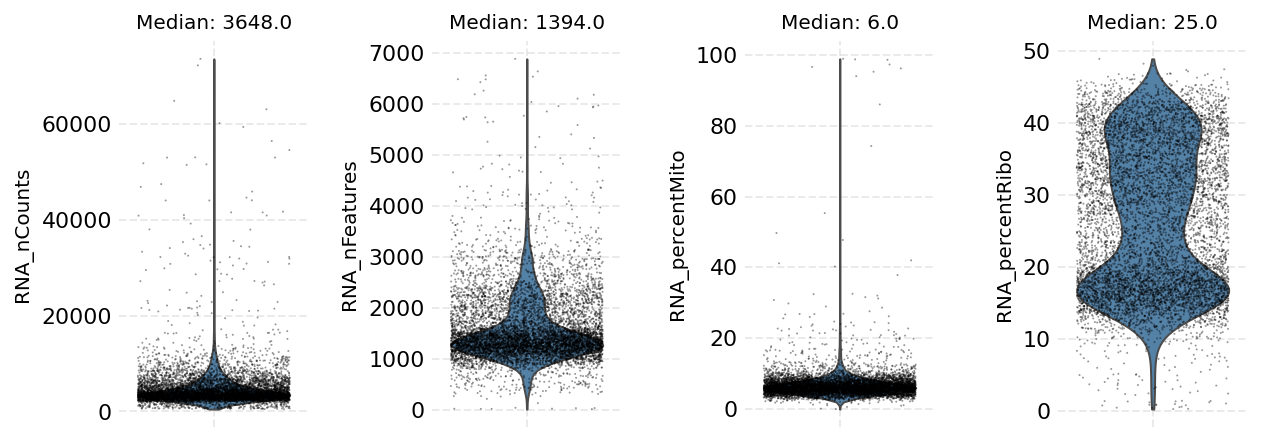

time: 1.44 s


In [12]:
ds.plot_cells_dists()

We can filter cells based on these cell attributes by providing upper and lower threshold values.

In [13]:
ds.filter_cells(attrs=['RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito'],
                highs=[15000, 4000, 15],
                lows=[1000, 500, 0])

INFO: 240 cells flagged for filtering out using attribute RNA_nCounts
INFO: 167 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 139 cells flagged for filtering out using attribute RNA_percentMito
time: 12.4 ms


Now we visualize the attributes again after filtering the values. 

*Note: the 'I' value given as the `cell_key` attribute signifies the column of the table that is set to `False` for cells that were filtered out or `True` for cells that are kept.*


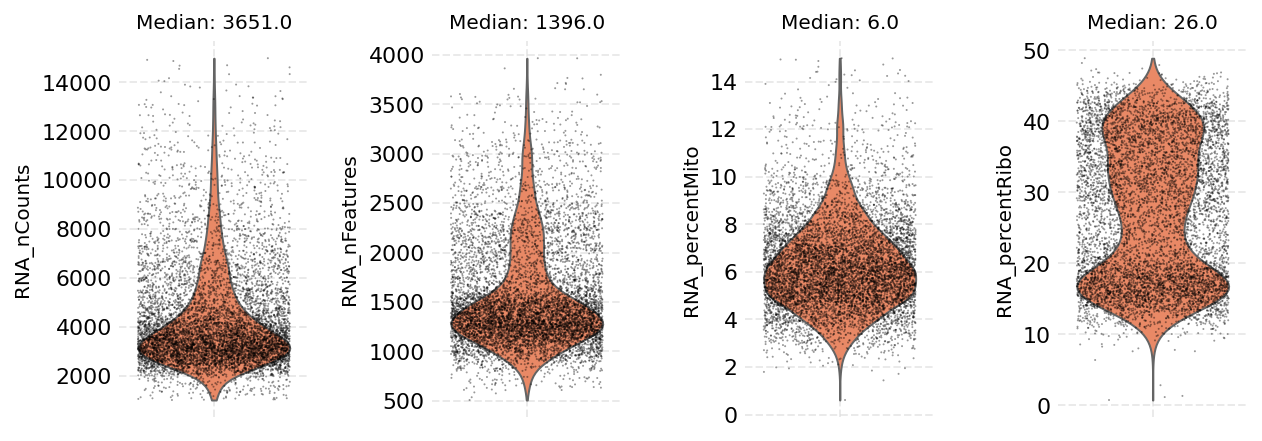

time: 627 ms


In [14]:
ds.plot_cells_dists(cell_key='I', color='coral')

Scarf attempts to store most of the data on disk immediately after it is processed. Below we can see that the calculated cell attributes can now be found under the 'cellData' level.

In [15]:
ds.show_zarr_tree()

/
 ├── ADT
 │   ├── counts (7865, 17) uint32
 │   └── featureData
 │       ├── I (17,) bool
 │       ├── dropOuts (17,) int64
 │       ├── ids (17,) <U6
 │       ├── nCells (17,) int64
 │       └── names (17,) <U23
 ├── RNA
 │   ├── counts (7865, 33538) uint32
 │   └── featureData
 │       ├── I (33538,) bool
 │       ├── dropOuts (33538,) int64
 │       ├── ids (33538,) <U15
 │       ├── nCells (33538,) int64
 │       └── names (33538,) <U16
 └── cellData
     ├── ADT_nCounts (7865,) float64
     ├── ADT_nFeatures (7865,) float64
     ├── I (7865,) bool
     ├── RNA_nCounts (7865,) float64
     ├── RNA_nFeatures (7865,) float64
     ├── RNA_percentMito (7865,) float64
     ├── RNA_percentRibo (7865,) float64
     ├── ids (7865,) <U18
     └── names (7865,) <U18
time: 6.54 ms


The data stored under the 'cellData' level can easily be accessed using the `cells` attribute of the `DataStore` object.

In [16]:
ds.cells.head()

I                 ids               names  ADT_nCounts  ADT_nFeatures  \
0  True  AAACCCAAGATTGTGA-1  AAACCCAAGATTGTGA-1        981.0           17.0   
1  True  AAACCCACATCGGTTA-1  AAACCCACATCGGTTA-1       1475.0           17.0   
2  True  AAACCCAGTACCGCGT-1  AAACCCAGTACCGCGT-1       7149.0           17.0   
3  True  AAACCCAGTATCGAAA-1  AAACCCAGTATCGAAA-1       6831.0           17.0   
4  True  AAACCCAGTCGTCATA-1  AAACCCAGTCGTCATA-1       6839.0           17.0   

   RNA_nCounts  RNA_nFeatures  RNA_percentMito  RNA_percentRibo  
0       6160.0         2194.0         8.668831        15.259740  
1       6713.0         2093.0         6.316103        19.037688  
2       3637.0         1518.0         8.056090        16.002200  
3       1244.0          737.0         9.003215        18.729904  
4       2611.0         1240.0         6.204519        16.353887

time: 20.9 ms


<div class="alert alert-block alert-info">
NOTE: We strongly discourage directly adding or removing the data from this table as Scarf will not be able to synchronize the changes to the disk. Instead use the methods of the <code>cells</code> attribute. Please refer to the <code>insert</code>, <code>fetch</code>, <code>fetch_all</code>, <code>drop</code> and <code>update_key</code> methods.
</div>

---
### 3) Feature selection

Similar to the cell table and the 'cellData' Zarr level, Scarf also saves the feature level data under 'featureData' that is located within each assay. For example, for the RNA assay the feature can be accessed as below:

In [17]:
ds.RNA.feats.head()

I              ids        names  dropOuts  nCells
0  False  ENSG00000243485  MIR1302-2HG      7865       0
1  False  ENSG00000237613      FAM138A      7865       0
2  False  ENSG00000186092        OR4F5      7865       0
3  False  ENSG00000238009   AL627309.1      7853      12
4  False  ENSG00000239945   AL627309.3      7865       0

time: 18.8 ms


The feature selection step is performed on the normalized data. The default normalization method for `RNAassay`-type data is library-size normalization, wherein the count values are divided by the sum of total values for a cell. These values are then multiplied by a scalar factor. The default value of this scalar factor is 1000. However, if the total counts in a cell are less than this value, then on multiplication with this scalar factor the values will be 'scaled up' (which is not a desired behaviour). In the filtering step above, we set the `low` threshold for `RNA_nCounts` at 1000, and hence it is safe to use 1000 as a scalar factor. The scalar factor can be set by modifying the `sf` attribute of the assay. Let's print the default value of `sf`

In [18]:
ds.RNA.sf

1000

time: 1.51 ms


Now the next step is to identify the highly variable genes in the dataset (for the RNA assay). This can be done using the `mark_hvgs` method of the assay. The parameters govern the min/max variance (corrected) and mean expression threshold for calling genes highly variable. 

The variance is corrected by first dividing genes into bins based on their mean expression values. Genes with minimum variance is selected from each bin and a Lowess curve is fitted to the mean-variance trend of these genes. `mark_hvgs` will by default run on the default assay.

A plot is produced, that for each gene shows the corrected variance on the y-axis and the non-zero mean (means from cells where the gene had a non-zero value) on the x-axis. The genes are colored in two gradients which indicate the number of cells where the gene was expressed. The colors are yellow to dark red for HVGs, and blue to green for non-HVGs.

The `mark_hvgs` function has a parameter `cell_key` that dictates which cells to use to identify the HVGs. The default value of this parameter is `I`, which means it will use all the cells that were not filtered out.

INFO: (RNA) Computing nCells
[########################################] | 100% Completed |  0.7s
INFO: (RNA) Computing normed_tot
[########################################] | 100% Completed |  0.6s
INFO: (RNA) Computing sigmas
[########################################] | 100% Completed |  0.8s
INFO: 1995 genes marked as HVGs


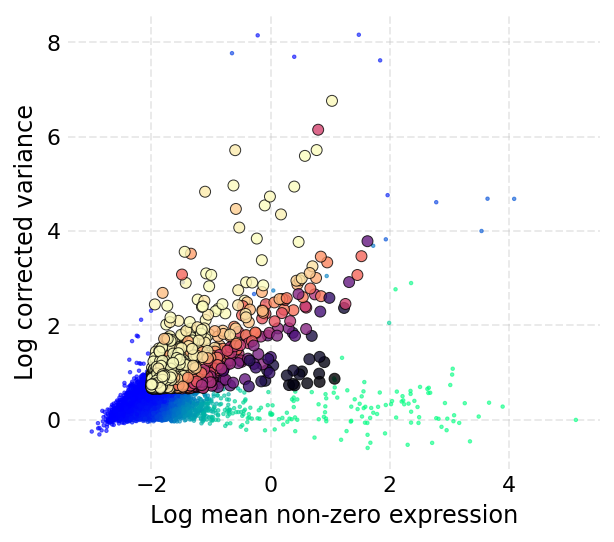

time: 4.04 s


In [19]:
ds.mark_hvgs(min_cells=20, top_n=2000, max_mean=1.9, min_mean=-2, max_var=7)

As a result of running `mark_hvgs`, the feature table now has an extra column **I__hvgs** which contains a `True` value for genes marked HVGs. The naming rule in Scarf dictates that cells used to identify HVGs are prepended to the column name (with a double underscore delimiter). Since we did not provide any `cell_key` parameter the default value was used, i.e. the filtered cells. This resulted in **I** becoming the prefix.

In [20]:
ds.RNA.feats.head()

I              ids        names  I__hvgs  dropOuts  nCells  \
0  False  ENSG00000243485  MIR1302-2HG    False      7865       0   
1  False  ENSG00000237613      FAM138A    False      7865       0   
2  False  ENSG00000186092        OR4F5    False      7865       0   
3  False  ENSG00000238009   AL627309.1    False      7853      12   
4  False  ENSG00000239945   AL627309.3    False      7865       0   

   stats_I_avg  stats_I_c_var__200__0.1  stats_I_normed_n  stats_I_normed_tot  \
0          NaN                      NaN               NaN                 NaN   
1          NaN                      NaN               NaN                 NaN   
2          NaN                      NaN               NaN                 NaN   
3          NaN                      NaN               NaN                 NaN   
4          NaN                      NaN               NaN                 NaN   

   stats_I_nz_mean  stats_I_sigmas  
0              NaN             NaN  
1              NaN             NaN  
2              NaN             NaN  
3              NaN             NaN  
4              NaN             NaN

time: 25.9 ms


### 4) Graph creation

Creating a neighbourhood graph of cells is the most critical step in any Scarf workflow. This step internally involves multiple substeps: 

- data normalization for selected features
- linear dimensionality reduction using PCA
- creating an approximate nearest neighbour graph index (using the HNSWlib library)
- querying cells against this index to identify nearest neighbours for each cell
- edge weight computation using the `compute_membership_strengths` function from the UMAP package
- fitting MiniBatch Kmeans (The kmeans centers are used later, for UMAP initialization)

`make_graph` method is responsible for graph construction. It method takes a mandatory parameter: `feat_key`. This should be a column in the feature metadata table that indicates which genes to use to create the graph. Since, we have already identified the `hvgs` in the step above, we use those genes. Note that we do not need to write *I__hvgs* but just *hvgs* as the value of the parameter. We also supply values for two very important parameters here: `k` (number of nearest neighbours to be queried for each cell) and `dims` (number of PCA dimensions to use for graph construction). `n_centroids` parameter controls number of clusters to create for the data using Kmeans algorithm. We perform a more accurate clustering of data in the later steps.

In [21]:
ds.make_graph(feat_key='hvgs', k=21, dims=30, n_centroids=100)

INFO: No value provided for parameter `log_transform`. Will use default value: True
INFO: No value provided for parameter `renormalize_subset`. Will use default value: True
INFO: No value provided for parameter `pca_cell_key`. Will use default value: I
INFO: Using PCA for dimension reduction
INFO: No value provided for parameter `ann_metric`. Will use default value: l2
INFO: No value provided for parameter `ann_efc`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_ef`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_m`. Will use default value: 48
INFO: No value provided for parameter `rand_state`. Will use default value: 4466
INFO: No value provided for parameter `local_connectivity`. Will use default value: 1.0
INFO: No value provided for parameter `bandwidth`. Will use default value: 1.5
INFO: Normalizing with feature subset
[########################################] | 100% Completed |  0.4s


Writing data to normed__I__hvgs/data: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

INFO: Calculating mean of norm. data
[###################################     ] | 88% Completed |  0.1s

[########################################] | 100% Completed |  0.2s
INFO: Calculating std. dev. of norm. data
[########################################] | 100% Completed |  0.2s


Estimating seed partitions: 100%|██████████| 4/4 [00:00<00:00,  9.88it/s]

INFO: Saving loadings to RNA/normed__I__hvgs/reduction__pca__30__I
INFO: Saving ANN index to RNA/normed__I__hvgs/reduction__pca__30__I/ann__l2__63__63__48__4466
INFO: Saving kmeans clusters to RNA/normed__I__hvgs/reduction__pca__30__I/kmeans__100__4466



Saving KNN graph: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]

INFO: ANN recall: 99.97%



Smoothening KNN distances: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

time: 26.2 s


All the results of `make_graph` step are saved under a name on the form '*normed\_\_{cell key}\_\_{feature key}*' (placeholders used in brackets here). In this case, since we did not provide a cell key it takes default value of `I`, which means all the non-filtered out cells. The feature key (`feat_key`) was set to `hvgs`. The Zarr directory is organized such that all the intermediate data is also saved. The intermediate data is organized in a hierarchy which triggers recomputation when upstream changes are detected. The parameter values are also saved in hierarchy level names. For example, 'reduction_pca_31_I' means that PCA linear dimension reduction with 31 PC axes was used and the PCA was fit across all the cells that have `True` value in column **I**.

In [22]:
ds.show_zarr_tree()

/
 ├── ADT
 │   ├── counts (7865, 17) uint32
 │   └── featureData
 │       ├── I (17,) bool
 │       ├── dropOuts (17,) int64
 │       ├── ids (17,) <U6
 │       ├── nCells (17,) int64
 │       └── names (17,) <U23
 ├── RNA
 │   ├── counts (7865, 33538) uint32
 │   ├── featureData
 │   │   ├── I (33538,) bool
 │   │   ├── I__hvgs (33538,) bool
 │   │   ├── dropOuts (33538,) int64
 │   │   ├── ids (33538,) <U15
 │   │   ├── nCells (33538,) int64
 │   │   └── names (33538,) <U16
 │   ├── normed__I__hvgs
 │   │   ├── data (7549, 1995) float64
 │   │   └── reduction__pca__30__I
 │   │       ├── ann__l2__63__63__48__4466
 │   │       │   └── knn__21
 │   │       │       ├── distances (7549, 21) float64
 │   │       │       ├── graph__1.0__1.5
 │   │       │       │   ├── edges (158529, 2) uint64
 │   │       │       │   └── weights (158529,) float64
 │   │       │       └── indices (7549, 21) uint64
 │   │       ├── kmeans__100__4466
 │   │       │   ├── cluster_centers (100, 30) float64
 │

The graph calculated by `make_graph` can be easily loaded using the `load_graph` method, like below. The graph is loaded as a sparse matrix of the cells that were used for creating a graph.

Next, we show how the graph can be accessed if required. However, as stated above, normally Scarf handles the graph loading internally where required. 

Because Scarf saves all the intermediate data, it might be the case that a lot of graphs are stored in the Zarr hierachy. `load_graph` will load only the latest graph that was computed (for the given assay, cell key and feat key). 

In [23]:
ds.load_graph(from_assay='RNA', cell_key='I', feat_key='hvgs', symmetric=False, upper_only=False)

<7549x7549 sparse matrix of type '<class 'numpy.float64'>'
	with 158529 stored elements in Compressed Sparse Row format>

time: 50.3 ms


The location of the latest graph can be accessed by `_get_latest_graph_loc` method. The latest graph location is set using the parameters used in the latest call to `make_graph`. If one needs to set the latest graph to one that was previously calculated then one needs to call `make_graph` with the corresponding parameters.

In [24]:
ds._get_latest_graph_loc(from_assay='RNA', cell_key='I', feat_key='hvgs')

'RNA/normed__I__hvgs/reduction__pca__30__I/ann__l2__63__63__48__4466/knn__21/graph__1.0__1.5'

time: 2.42 ms


---
### 5) Low dimensional embedding and clustering

Next we run UMAP on the graph calculated above. Here we will not provide which assay, cell key or feature key to be used, because we want the UMAP to run on the default assay with all the non-filtered out cells and with the feature key used to calculate the latest graph. We can provide the parameter values for the UMAP algorithm here.

In [25]:
ds.run_umap(fit_n_epochs=200, spread=5, min_dist=2, parallel=True)

/home/parashar/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
time: 9.64 s


The UMAP results are saved in the cell metadata table as seen below in columns: **RNA_UMAP1** and **RNA_UMAP2**

In [26]:
ds.cells.head()

I                 ids               names  ADT_nCounts  ADT_nFeatures  \
0  True  AAACCCAAGATTGTGA-1  AAACCCAAGATTGTGA-1        981.0           17.0   
1  True  AAACCCACATCGGTTA-1  AAACCCACATCGGTTA-1       1475.0           17.0   
2  True  AAACCCAGTACCGCGT-1  AAACCCAGTACCGCGT-1       7149.0           17.0   
3  True  AAACCCAGTATCGAAA-1  AAACCCAGTATCGAAA-1       6831.0           17.0   
4  True  AAACCCAGTCGTCATA-1  AAACCCAGTCGTCATA-1       6839.0           17.0   

   RNA_UMAP1  RNA_UMAP2  RNA_nCounts  RNA_nFeatures  RNA_percentMito  \
0  30.626955  -5.998992       6160.0         2194.0         8.668831   
1  31.344912 -11.651943       6713.0         2093.0         6.316103   
2  27.955187   7.075594       3637.0         1518.0         8.056090   
3   4.638202 -32.349285       1244.0          737.0         9.003215   
4   8.310675 -29.801958       2611.0         1240.0         6.204519   

   RNA_percentRibo  
0        15.259740  
1        19.037688  
2        16.002200  
3        18.729904  
4        16.353887

time: 21.6 ms


`plot_layout` is a versatile method to create a [scatter plot](https://datavizcatalogue.com/methods/scatterplot.html) using Scarf. Here we can plot the UMAP coordinates of all the non-filtered out cells.

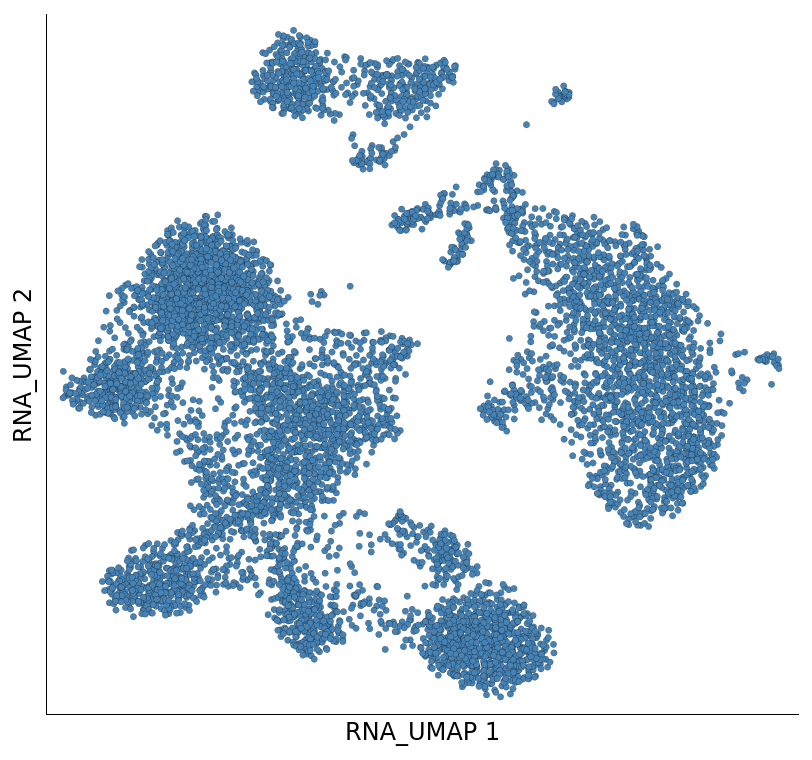

time: 236 ms


In [27]:
ds.plot_layout(layout_key='RNA_UMAP')

`plot_layout` can be used to easily visualize data from any column of the cell metadata table. Next, we visualize the number of genes expressed in each cell.

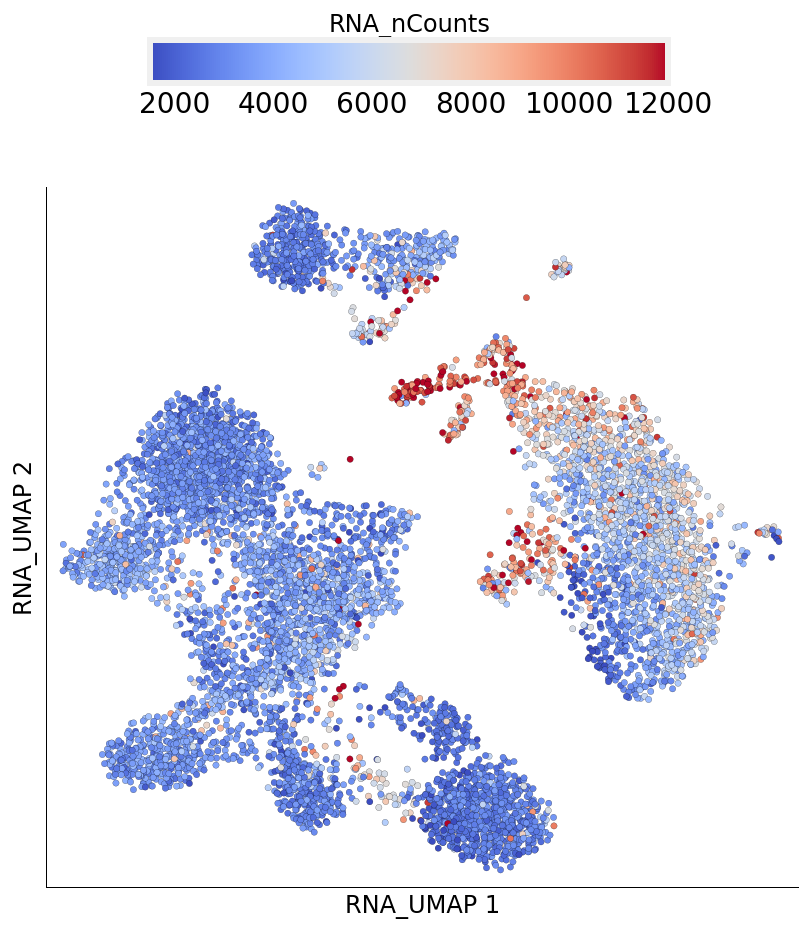

time: 767 ms


In [28]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_nCounts', cmap='coolwarm')

Identifying clusters of cells is one of the central tenets of single cell approaches. Scarf includes two graph clustering methods and any (or even both) can be used on the dataset. The methods start with the same graph as the UMAP algorithm above to minimize the disparity between the UMAP and clustering results. The two clustering methods are:

- **Paris**: This is the default clustering algorithm.
- **Leiden**: Leiden is a widely used graph clustering algorithm in single-cell genomics.

Paris is the default algorithm in Scarf due to its ability to highlight cluster relationships. [Paris](https://github.com/tbonald/paris) is a hierarchical graph clustering algorithm that is based on node pair sampling. Paris creates a dendrogram of cells which can then be cut to obtain desired number of clusters. The advantage of using Paris, especially in the larger datasets, is that once the dendrogram has been created one can change the desired number of clusters with minimal computation overhead.

In [29]:
ds.run_clustering(n_clusters=20)

time: 1.27 s


The results of the clustering algorithm are saved in the cell metadata table. In this case, they have been saved under the column name **RNA_cluster**.

In [30]:
ds.cells.head()

I                 ids               names  ADT_nCounts  ADT_nFeatures  \
0  True  AAACCCAAGATTGTGA-1  AAACCCAAGATTGTGA-1        981.0           17.0   
1  True  AAACCCACATCGGTTA-1  AAACCCACATCGGTTA-1       1475.0           17.0   
2  True  AAACCCAGTACCGCGT-1  AAACCCAGTACCGCGT-1       7149.0           17.0   
3  True  AAACCCAGTATCGAAA-1  AAACCCAGTATCGAAA-1       6831.0           17.0   
4  True  AAACCCAGTCGTCATA-1  AAACCCAGTCGTCATA-1       6839.0           17.0   

   RNA_UMAP1  RNA_UMAP2  RNA_cluster  RNA_nCounts  RNA_nFeatures  \
0  30.626955  -5.998992            4       6160.0         2194.0   
1  31.344912 -11.651943            4       6713.0         2093.0   
2  27.955187   7.075594            5       3637.0         1518.0   
3   4.638202 -32.349285            3       1244.0          737.0   
4   8.310675 -29.801958            3       2611.0         1240.0   

   RNA_percentMito  RNA_percentRibo  
0         8.668831        15.259740  
1         6.316103        19.037688  
2         8.056090        16.002200  
3         9.003215        18.729904  
4         6.204519        16.353887

time: 26.1 ms


We can visualize the results using the `plot_layout` method again:

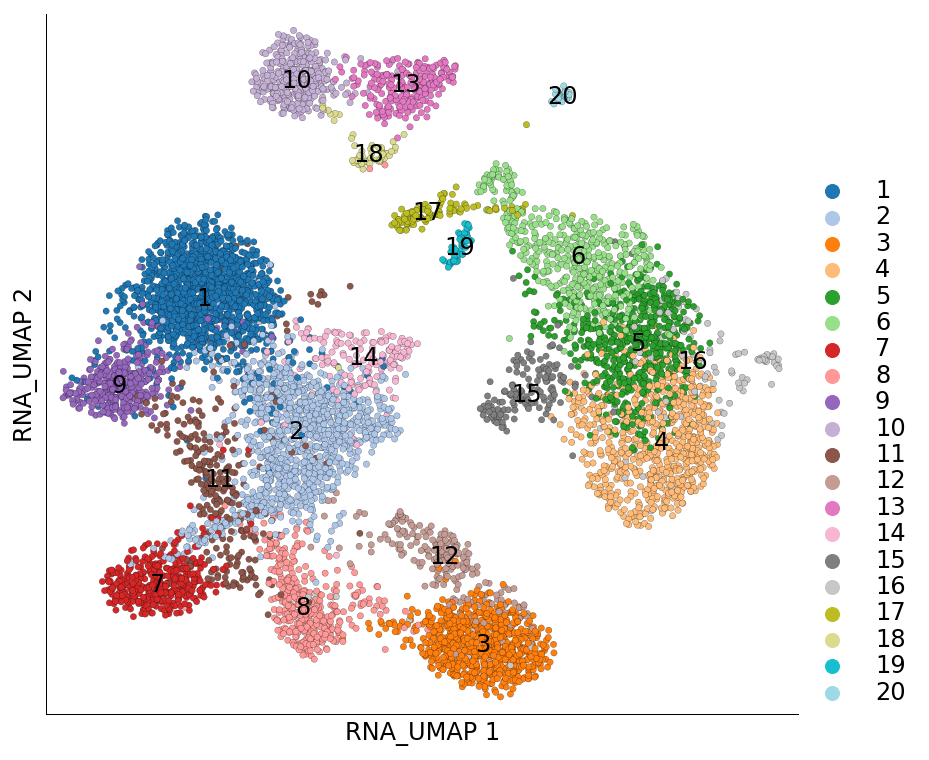

time: 662 ms


In [31]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_cluster')

Leiden clustering provides very accurate results

In [32]:
ds.run_leiden_clustering(resolution=2)

time: 264 ms


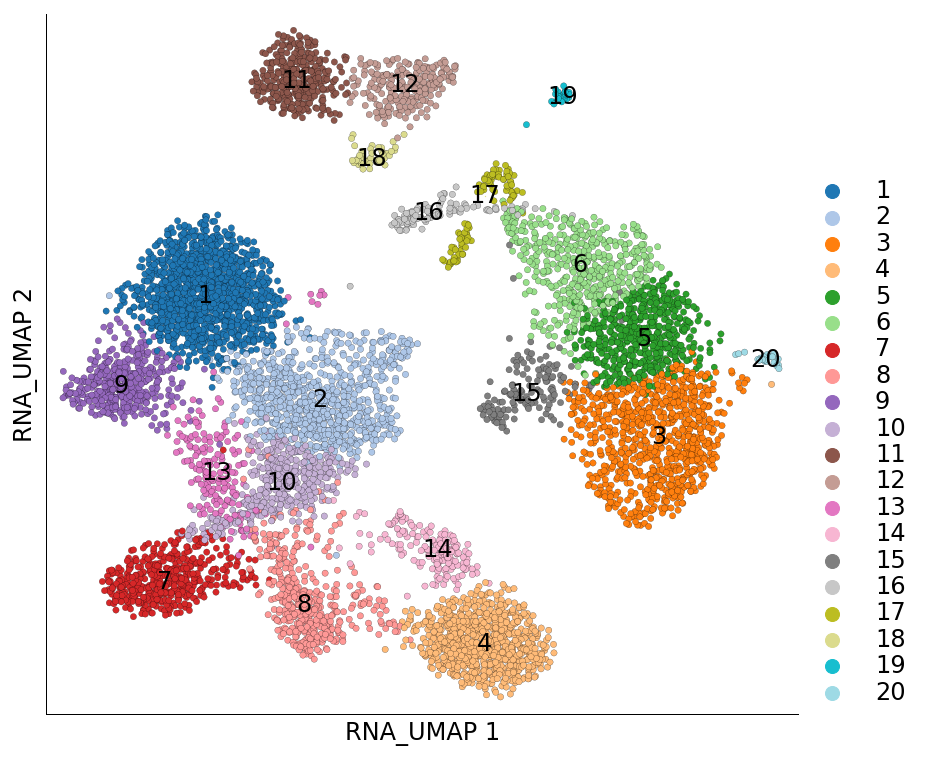

time: 686 ms


In [33]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_leiden_cluster')

There has been a lot of discussion over the choice of non-linear dimensionality reduction for single-cell data. tSNE was initially considered an excellent solution, but has gradually lost out to UMAP because the magnitude of relations between the clusters cannot easily be discerned in a tSNE plot. Scarf contains an implementation of tSNE that runs directly on the graph structure of cells. So, essentially the same data that was used to create the UMAP and clustering is used. Additionally, to minimize the differences between the UMAP and tSNE, we use the same initial coordinates of tSNE that were used for UMAP, i.e. the first two (in case of 2D) PC axes of PCA of kmeans cluster centers. We have found that tSNE is actually a complementary technique to UMAP. While UMAP focuses on highlighting the cluster relationship, tSNE highlights the heterogeneity of the dataset. As we show in the sample integration vignette, using tSNE can be better at visually accessing the extent of heterogeneity compared to UMAP. The biggest reason, however, to run Scarf's implementation of graph tSNE could be the runtime. It can be an order of magnitude faster than UMAP on large datasets.

In [34]:
ds.run_tsne(alpha=10, box_h=1, early_iter=250, max_iter=500, parallel=True)

Saving KNN matrix in MTX format: 100%|██████████| 8/8 [00:00<00:00, 21.03it/s]


INFO: b'Number of vertices: 7549'
INFO: b'Embedding dimensions: 2'
INFO: b'Rescaling parameter \xce\xbb: 1'
INFO: b'Early exag. multiplier \xce\xb1: 10'
INFO: b'Maximum iterations: 500'
INFO: b'Early exag. iterations: 250'
INFO: b'Box side length h: 1'
INFO: b'Drop edges originating from leaf nodes? 0'
INFO: b'Number of processes: 4'
INFO: b'41 out of 7549 nodes already stochastic'
INFO: b'Skipping \xce\xbb rescaling...'
INFO: b'Nested dissection permutation...Permuting matrixDONE'
INFO: b'm = 7549| n = 7549| nnnz = 266358'
INFO: b'Working with double precision'
INFO: b'Iteration 1: error is 93.3761'
INFO: b'Iteration 50: error is 76.2102 (50 iterations in 0.209419 seconds)'
INFO: b'Iteration 100: error is 71.3956 (50 iterations in 0.170928 seconds)'
INFO: b'Iteration 150: error is 70.2095 (50 iterations in 0.182797 seconds)'
INFO: b'Iteration 200: error is 69.6352 (50 iterations in 0.169502 seconds)'
INFO: b'Iteration 250: error is 4.64347 (50 iterations in 0.181093 seconds)'
INFO: b'

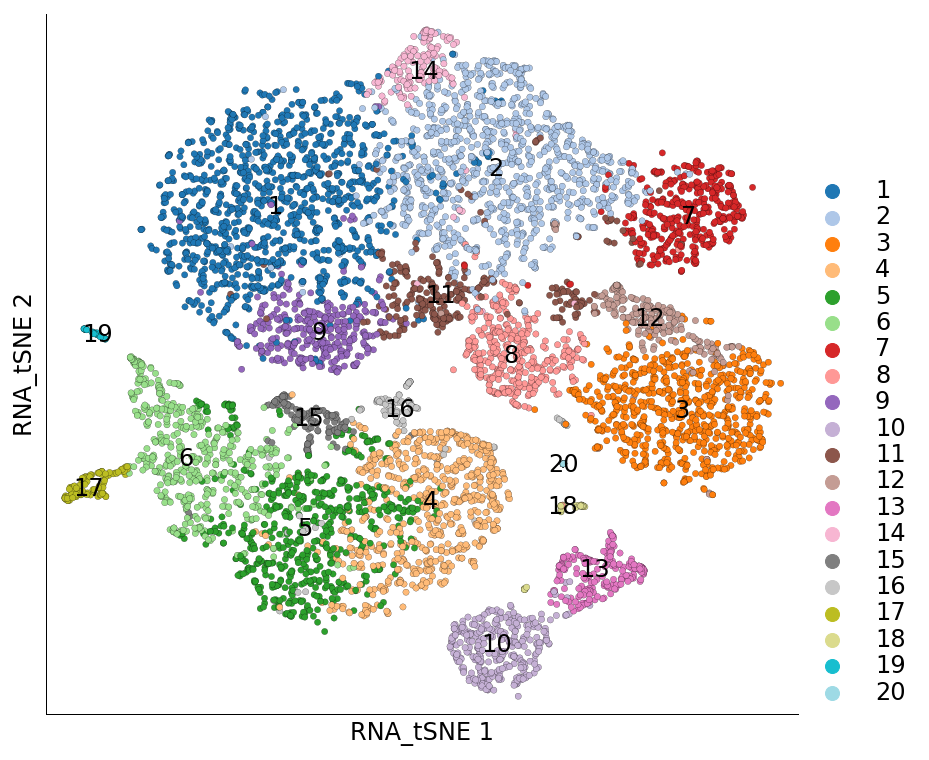

time: 685 ms


In [35]:
# Here we run plot_layout under exception catching because if you are not on Linux then the `run_tnse` would have failed.
try:
    ds.plot_layout(layout_key='RNA_tSNE', color_by='RNA_cluster')
except KeyError:
    print ("'RNA_tSNE1' not found in MetaData")

We saw an over 2x speedup compared to UMAP using tSNE with the given parameters. It is harder to compare the distances between the clusters here but easier to visually gauge the size of clusters and intra-cluster heterogeneity.

Discerning similarity between clusters can be difficult from visual inspection alone, especially for tSNE plots. `plot_cluster_tree` function plots the relationship between clusters as a binary tree. This tree is simply a condensation of the dendrogram obtained using Paris clustering.

Identifying the top node for cluster: 100%|██████████| 20/20 [00:00<00:00, 594.57it/s]


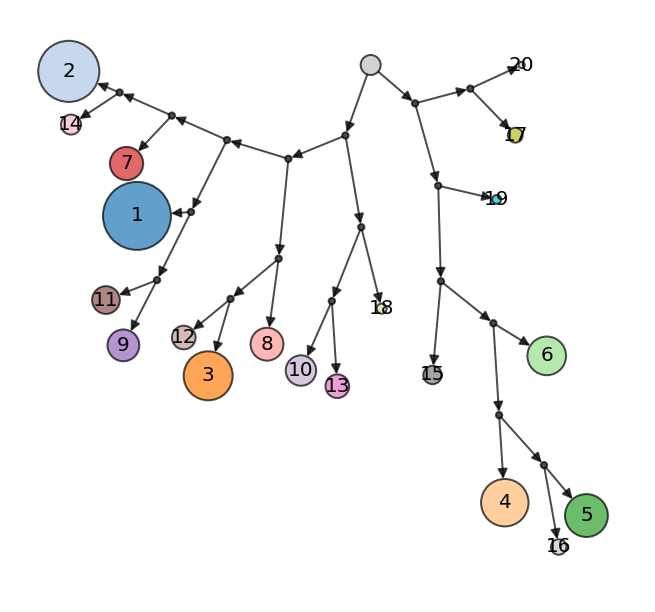

time: 704 ms


In [36]:
ds.plot_cluster_tree(cluster_key='RNA_cluster', width=1)

The tree is free form (i.e the position of clusters doesn't convey any meaning) but allows inspection of cluster similarity based on branching pattern. The sizes of clusters indicate the number of cells present in each cluster. The tree starts from the root node (black dot with no incoming edges). 

---
### 6) Marker gene identification

Now we can identify the genes that are differentially expressed between the clusters using the `run_marker_search` method. The method to identify the differentially expressed genes in Scarf is optimized to obtain quick results. We have not compared the sensitivity of our method compared to other differential expression detecting methods and expect specialized methods to be more sensitive and accurate to varying degrees. Our method is designed to quickly obtain key marker genes for populations from a large dataset. For each gene individually, following steps are carried out:

- Expression values are converted to ranks (dense format) across cells.
- A mean of ranks is calculated for each group of cells
- The mean value for each group is divided by the sum of mean values to obtain the 'specificity score'
- The gene is saved as a marker gene if it's specificity score is higher than a given threshold.

This method does not perform any statistical test of significance and uses 'specificity score' as a measure of importance of each gene for a cluster.

In [37]:
ds.run_marker_search(group_key='RNA_cluster', threshold=0.25)

Finding markers: 100%|██████████| 271/271 [00:19<00:00, 14.13it/s]


time: 19.3 s


Using the `plot_marker_heatmap` method, we can also plot a heatmap with the top marker genes from each cluster. The method will calculate the mean expression value for each gene from each cluster.


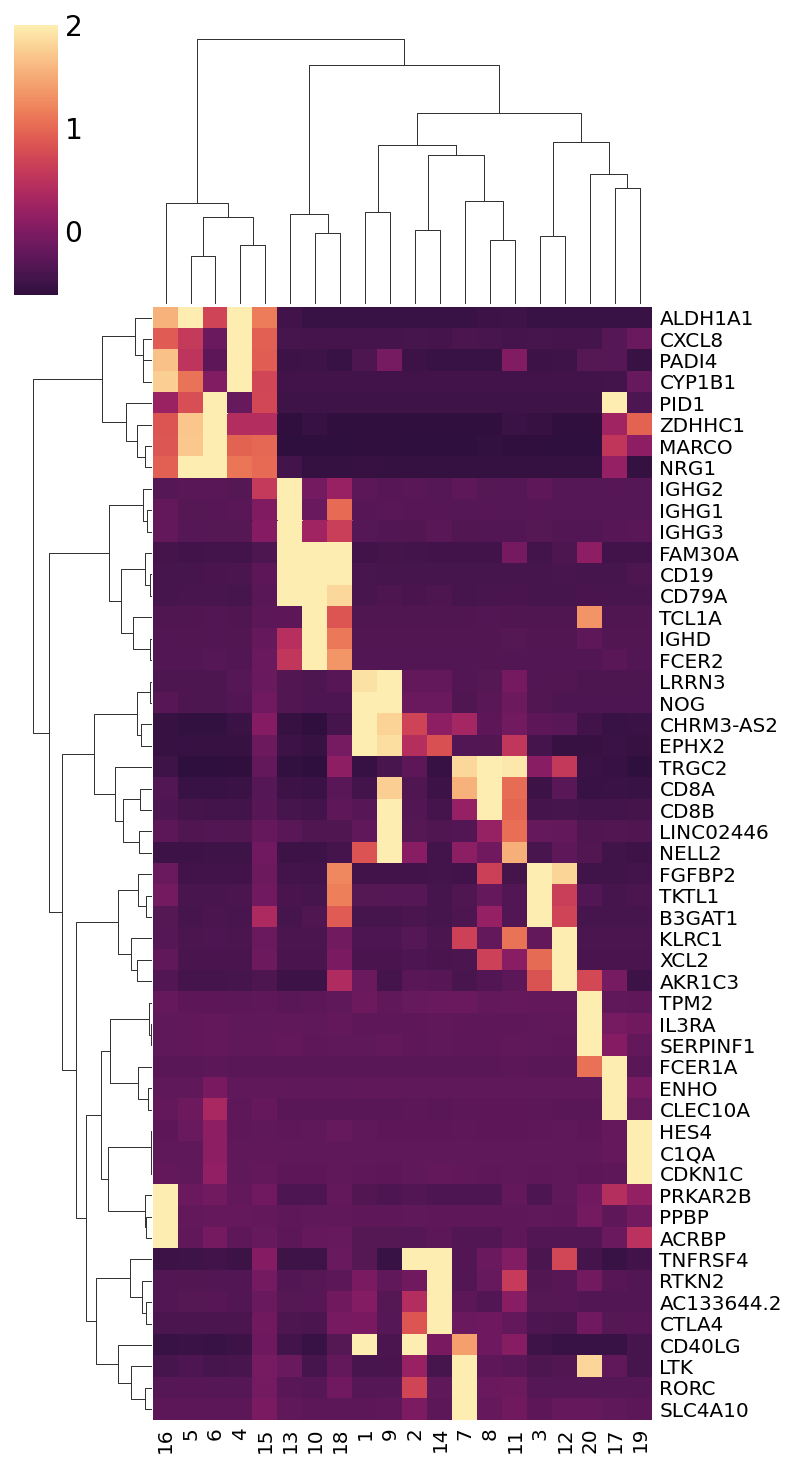

time: 2.03 s


In [38]:
ds.plot_marker_heatmap(group_key='RNA_cluster', topn=3)

We can directly visualize the expression values for a gene of interest. It is usually a good idea to visually confirm the the gene expression pattern across the cells atleast this way.

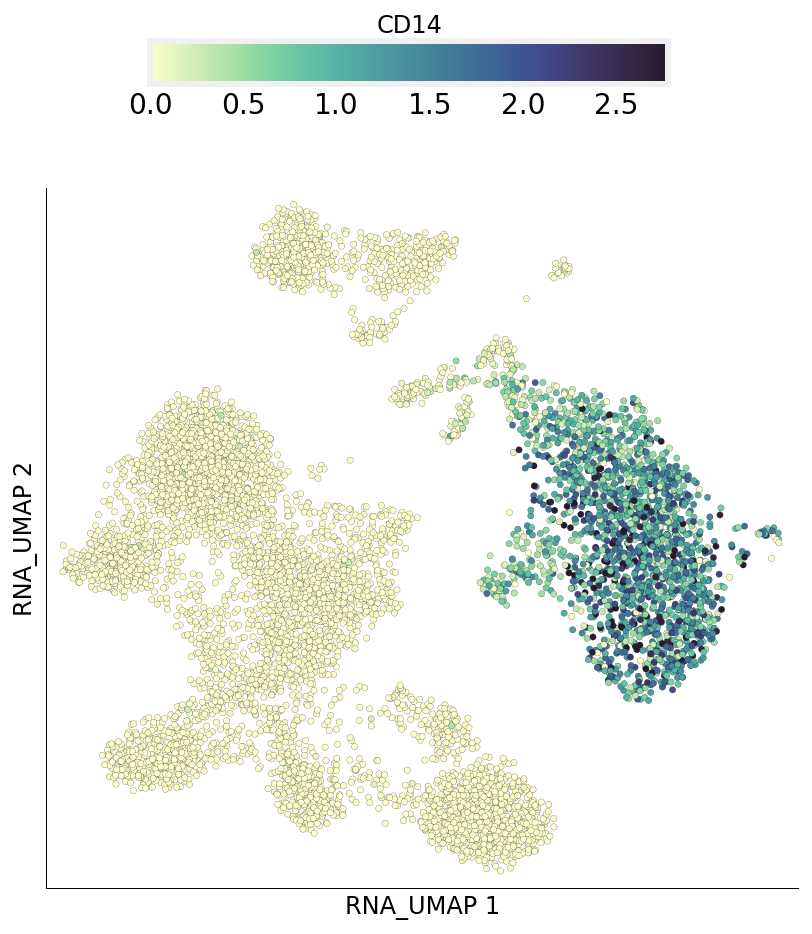

time: 797 ms


In [39]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='CD14')

---
### 7) Working with non-default assays: surface protein expression (ADT) data

Here, we show how to work with non-default assays. We have surface protein data present, in the ADT assay. Let's check out the feature table for this assay:


In [40]:
ds.ADT.feats.head()

I   ids           names  dropOuts  nCells
0  True   CD3   CD3_TotalSeqB         1    7864
1  True   CD4   CD4_TotalSeqB         1    7864
2  True  CD8a  CD8a_TotalSeqB         2    7863
3  True  CD14  CD14_TotalSeqB         1    7864
4  True  CD15  CD15_TotalSeqB         1    7864

time: 14.8 ms


We can manually filter out the control antibodies by updating **I** to be False for those features.

In [41]:
ds.ADT.feats.update_key(~ds.ADT.feats.to_pandas_dataframe(['names'])['names'].str.contains('control').values, 'I')
ds.ADT.feats.head(n=ds.ADT.feats.N)

I     ids                    names  dropOuts  nCells
0    True     CD3            CD3_TotalSeqB         1    7864
1    True     CD4            CD4_TotalSeqB         1    7864
2    True    CD8a           CD8a_TotalSeqB         2    7863
3    True    CD14           CD14_TotalSeqB         1    7864
4    True    CD15           CD15_TotalSeqB         1    7864
5    True    CD16           CD16_TotalSeqB         1    7864
6    True    CD56           CD56_TotalSeqB         1    7864
7    True    CD19           CD19_TotalSeqB       163    7702
8    True    CD25           CD25_TotalSeqB         4    7861
9    True  CD45RA         CD45RA_TotalSeqB         1    7864
10   True  CD45RO         CD45RO_TotalSeqB         1    7864
11   True    PD-1           PD-1_TotalSeqB         2    7863
12   True   TIGIT          TIGIT_TotalSeqB        16    7849
13   True   CD127          CD127_TotalSeqB         3    7862
14  False   IgG2a  IgG2a_control_TotalSeqB        26    7839
15  False    IgG1   IgG1_control_TotalSeqB         9    7856
16  False   IgG2b  IgG2b_control_TotalSeqB       226    7639

time: 22.5 ms


Assays named ADT are automatically created as objects of the `ADTassay` class, which uses CLR (centred log ratio) normalization as the default normalization method.

In [42]:
print (ds.ADT)
print (ds.ADT.normMethod.__name__)

ADTassay ADT with 14(17) features
norm_clr
time: 20.9 ms


Now we create a new graph of cells using just the `ADT` data.

In [43]:
ds.make_graph(from_assay='ADT', feat_key='I', k=11, dims=11, n_centroids=100, log_transform=False)

INFO: No value provided for parameter `renormalize_subset`. Will use default value: True
INFO: No value provided for parameter `pca_cell_key`. Will use default value: I
INFO: Using PCA for dimension reduction
INFO: No value provided for parameter `ann_metric`. Will use default value: l2
INFO: No value provided for parameter `ann_efc`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_ef`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_m`. Will use default value: 48
INFO: No value provided for parameter `rand_state`. Will use default value: 4466
INFO: No value provided for parameter `local_connectivity`. Will use default value: 1.0
INFO: No value provided for parameter `bandwidth`. Will use default value: 1.5


Writing data to normed__I__I/data: 100%|██████████| 4/4 [00:00<00:00, 12.25it/s]

INFO: Calculating mean of norm. data
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s
INFO: Calculating std. dev. of norm. data
[########################################] | 100% Completed |  0.1s


Estimating seed partitions: 100%|██████████| 4/4 [00:00<00:00, 24.59it/s]

INFO: Saving loadings to ADT/normed__I__I/reduction__pca__11__I
INFO: Saving ANN index to ADT/normed__I__I/reduction__pca__11__I/ann__l2__50__50__48__4466
INFO: Saving kmeans clusters to ADT/normed__I__I/reduction__pca__11__I/kmeans__100__4466



Saving KNN graph: 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]

INFO: ANN recall: 99.99%



Smoothening KNN distances: 100%|██████████| 1/1 [00:00<00:00, 42.24it/s]

time: 1.98 s


Run UMAP on the `ADT` graph:


In [44]:
ds.run_umap(from_assay='ADT', fit_n_epochs=200, parallel=True)

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
time: 8.3 s


One can check concordance between the RNA and ADT assays by visualizing the RNA cluster information on ADT data:

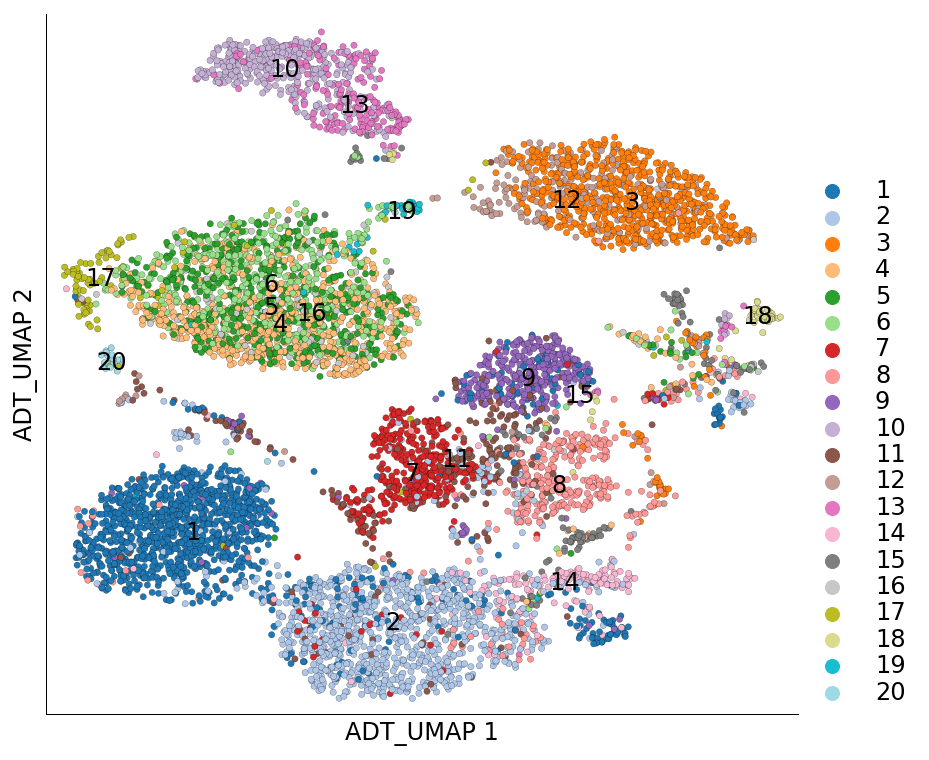

time: 653 ms


In [45]:
ds.plot_layout(layout_key='ADT_UMAP', color_by='RNA_cluster')

We can also run the clustering directly on the `ADT` graph and visualize it on the UMAP plot:

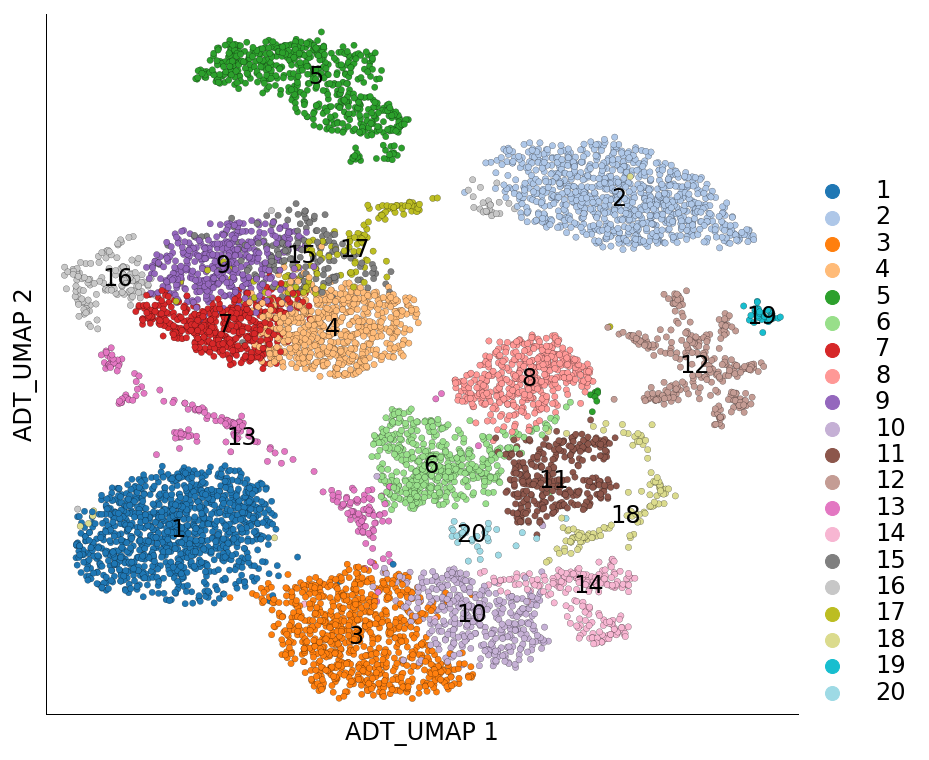

time: 788 ms


In [46]:
ds.run_leiden_clustering(from_assay='ADT', resolution=1.4)
ds.plot_layout(layout_key='ADT_UMAP', color_by='ADT_leiden_cluster')

Or another way, visualize the ADT clusters on the RNA UMAP:

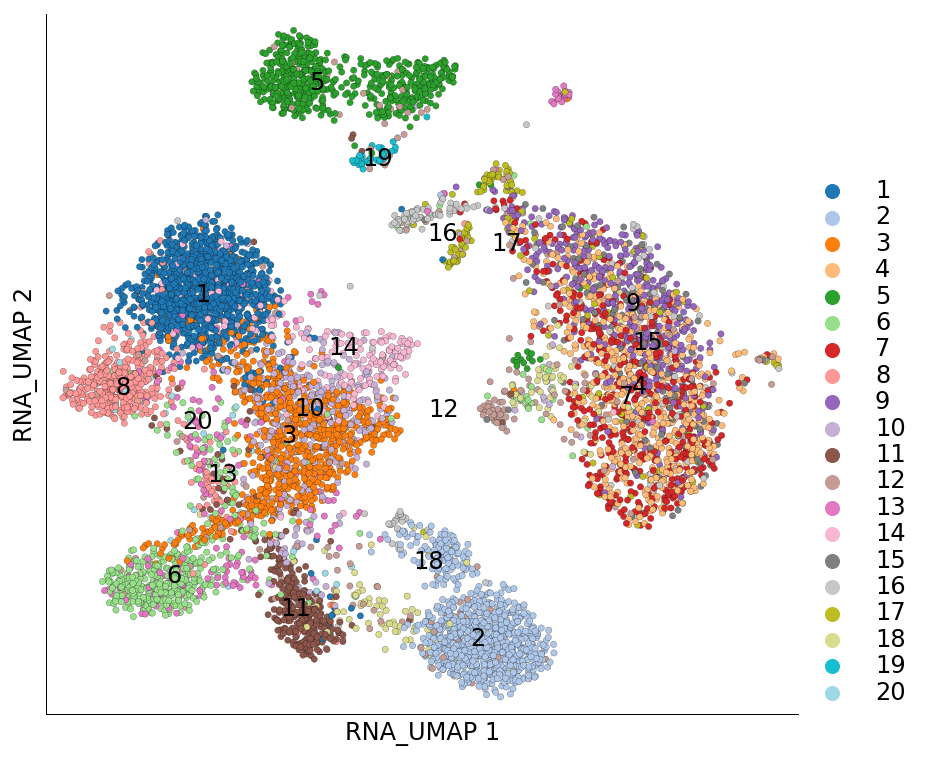

time: 703 ms


In [47]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='ADT_leiden_cluster')

Individual ADT expression can be visualized in both UMAPs easily.

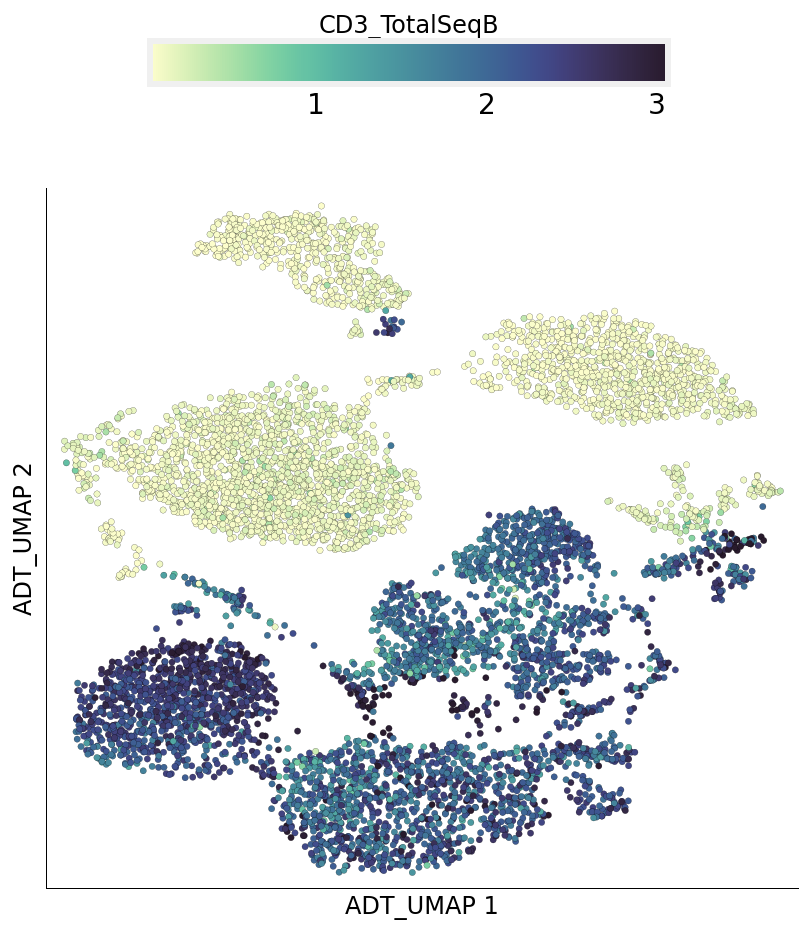

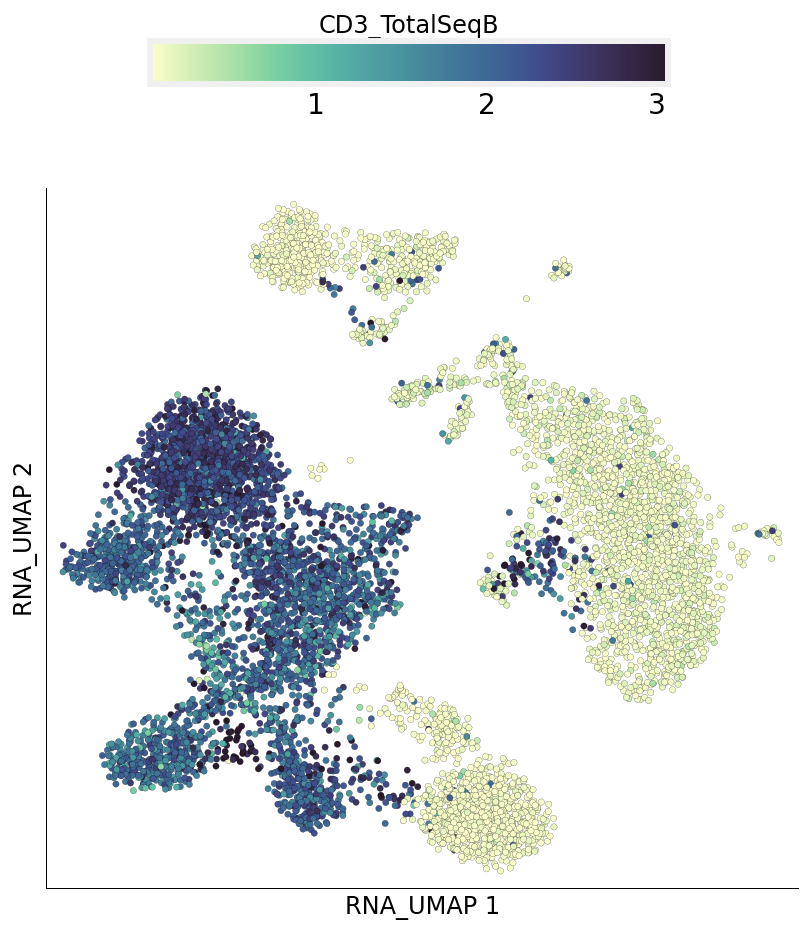

time: 1.61 s


In [48]:
ds.plot_layout(from_assay='ADT', layout_key='ADT_UMAP', color_by='CD3_TotalSeqB')
ds.plot_layout(from_assay='ADT', layout_key='RNA_UMAP', color_by='CD3_TotalSeqB')

---
That is all for this vignette.